# Joint embedding of fragmentation spectra and chemical compounds

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [12]:
import keras
from keras.callbacks import History, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from livelossplot import PlotLossesKeras

from rdkit.Chem import AllChem
from rdkit import Chem

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

from functions import *

### Load MoNA data

Data contains SMILES of known molecules and also their fragmentation spectra

In [3]:
label = 'small'
data_path = '../data/representation_3/data_%s.txt' % label
data = load_data(data_path, num_samples=100000, remove_duplicate_spectra=True, filter_count=1)

Loaded 1000
Loaded 2000
Loaded 3000
Loaded 4000
Loaded 5000
Loaded 6000
Loaded 7000
Before filtering array (7744, 6183) vocab (6183,)
2337 mzs to remove
After filtering array (7744, 3846) vocab (3846,)


### Create spectra embedding

Load a simple dense model. This was trained on the training data and is used to map

- From: fragmentation spectra 
- To: 100-dimensional vector representation.

TODO: try better representation: vae, LDA topic decomposition?

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3846)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               384700    
_________________________________________________________________
dense_2 (Dense)              (None, 3846)              388446    
Total params: 773,146
Trainable params: 773,146
Non-trainable params: 0
_________________________________________________________________


/Users/joewandy/anaconda/envs/smiles2spectra/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


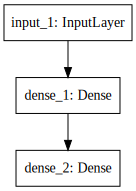

In [4]:
spectra_autoencoder = keras.models.load_model('../models/spectra_autoencoder_small.h5')
spectra_encoder = keras.models.load_model('../models/spectra_encoder_small.h5')
spectra_decoder = keras.models.load_model('../models/spectra_decoder_small.h5')
spectra_autoencoder.summary()
svg = plot_model_in_notebook(spectra_autoencoder)
svg

In [5]:
spectra_latent = spectra_encoder.predict(data['spectra'])
print(spectra_latent.shape)

(7744, 100)


[ 65.038 125.048 156.012 173.038]


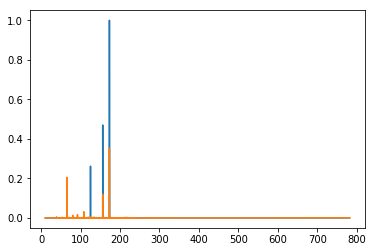

[173.038]


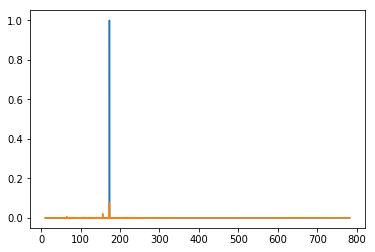

[125.048 156.012 173.038]


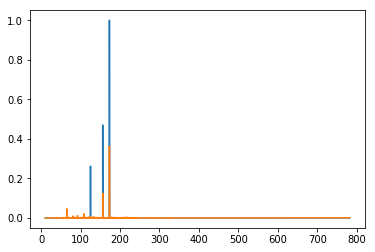

[175.033 202.045]


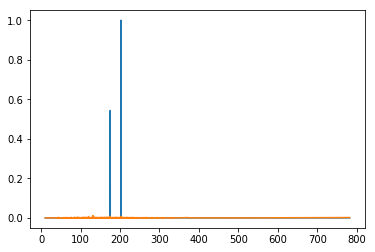

[202.045]


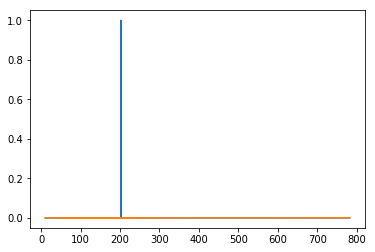

[131.06  143.06  175.032]


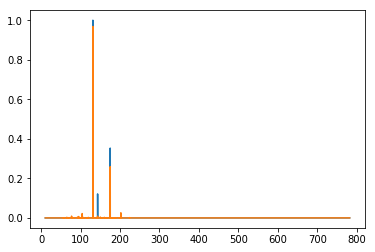

[131.06  175.032]


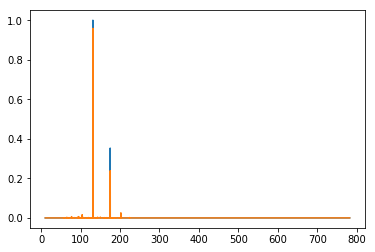

[131.06]


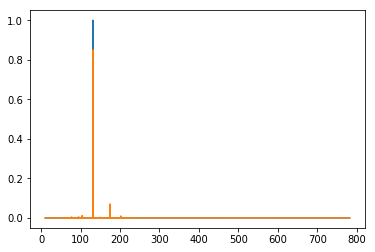

[128.046 172.072]


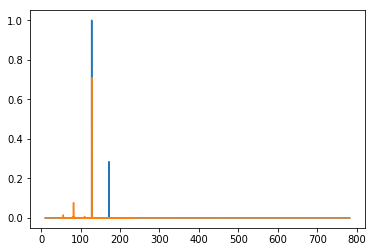

[128.046]


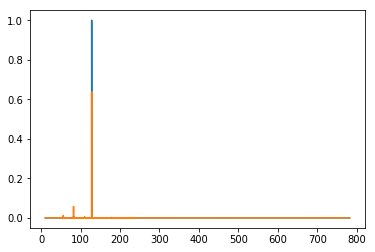

In [6]:
spectra_decoded = spectra_decoder.predict(spectra_latent)
for idx in range(10):
    pos = np.nonzero(data['spectra'][idx])
    print(data['vocab'][pos])
    plt.plot(data['vocab'], data['spectra'][idx])
    plt.plot(data['vocab'], spectra_decoded[idx])
    plt.show()

In [7]:
spectra_latent = StandardScaler().fit_transform(spectra_latent)

### Create SMILES embedding

Load the molecular autoencoder model from https://github.com/maxhodak/keras-molecules, trained on 500k small compounds from Pubchem. This is used to map:

- From: SMILES string.
- To: 100-dimensional vector representation.

In [8]:
# model_file = '../models/pubchem_500k_val_loss_0.4368_val_acc_0.9654_MoleculeVAE.h5'
# charset_file = '../preprocessed/pubchem_500k_charset.p'
# LATENT_DIM = 100

# molecule_autoencoder, charset = load_molecule_vae(model_file, charset_file, LATENT_DIM)
# molecule_autoencoder.autoencoder.summary()
# plot_model_in_notebook(molecule_autoencoder.autoencoder)

In [9]:
# input_array = get_input_arr(data['smiles'], charset)
# mona_latent = encode(molecule_autoencoder, input_array)
# mona_latent = StandardScaler().fit_transform(mona_latent)
# print(mona_latent.shape)

Try using molecular fingerprint instead

In [17]:
from rdkit.Chem.Fingerprints import FingerprintMols

In [47]:
fingerprints = []
spectra = []
assert len(data['smiles']) == len(data['spectra'])

max_length = 0
for i in range(len(data['smiles'])):
    mol = Chem.MolFromSmiles(data['smiles'][i])
    spec = data['spectra'][i]
    try:
        fp = FingerprintMols.FingerprintMol(mol)
        bits = np.array(list(fp.GetOnBits()))
        if max(bits) > max_length:
            max_length = max(bits)
        fingerprints.append(bits)
        spectra.append(data['spectra'][i])
    except Exception:
        print('Invalid smile', data['smiles'][i])
        continue

Invalid smile Oc2cccc1nnnc12
Invalid smile Oc2cccc1nnnc12
Invalid smile Oc2cccc1nnnc12
Invalid smile Cc(n3)c(n1)c(cc3)c(c2)c(ccc2)1
Invalid smile Cc(n3)c(n1)c(cc3)c(c2)c(ccc2)1
Invalid smile Cc(n3)c(n1)c(cc3)c(c2)c(ccc2)1
Invalid smile [Cl-1]
Invalid smile [Cl-]
Invalid smile [Cl-1]
Invalid smile Oc(n2)c(n1)c(nc2)cn1
Invalid smile O=c(n1)c(=O)c(c2)c(ccc2)1
Invalid smile O=c(n1)c(=O)c(c2)c(ccc2)1
Invalid smile O=c(n1)c(=O)c(c2)c(ccc2)1
Invalid smile Nc(c2)c(c1)c(cc2)nc1
Invalid smile Nc(c2)c(c1)c(cc2)nc1
Invalid smile Nc(c2)c(c1)c(cc2)nc1
Invalid smile Nc(c1)cc(c2)c(nc2)c1
Invalid smile Nc(c1)cc(c2)c(nc2)c1
Invalid smile Nc(n1)nc(c2)c(ccc2)1
Invalid smile Nc(n1)nc(c2)c(ccc2)1
Invalid smile Nc(n1)nc(c2)c(ccc2)1
Invalid smile Nc(n1)nnc1
Invalid smile Nc(n1)nnc1
Invalid smile CC(=O)NC(C(O)=O)Cc(c1)ncn1
Invalid smile CC(=O)NC(C(O)=O)Cc(c1)ncn1
Invalid smile CC(=O)NCCc(c1)ncn1
Invalid smile CC(=O)NCCc(c1)ncn1
Invalid smile CC(=O)NCCc(c1)ncn1
Invalid smile NC(=O)c(n1)c(N)nc1
Invalid smile NC(

In [48]:
len(fingerprints)

7517

In [49]:
fingerprints[0]

array([  2,   3,   4,   9,  13,  14,  17,  19,  20,  24,  27,  30,  34,
        35,  43,  44,  45,  46,  51,  57,  61,  63,  64,  66,  68,  70,
        74,  78,  81,  83,  91, 101, 103, 105, 107, 112, 113, 114, 119,
       120, 127, 128, 135, 137, 139, 140, 146, 147, 148, 149, 151, 152,
       155, 159, 161, 165, 166, 178, 181, 186, 190, 192, 193, 194, 195,
       200, 201, 203, 205, 206, 208, 209, 215, 220, 236, 237, 238, 243,
       244, 246, 248, 252, 253, 255, 258, 262, 263, 272, 274, 275, 276,
       278, 279, 280, 284, 286, 288, 289, 294, 300, 301, 302, 304, 305,
       306, 311, 312, 313, 320, 323, 329, 330, 331, 336, 341, 344, 351,
       353, 359, 362, 363, 364, 365, 369, 371, 373, 378, 381, 383, 394,
       395, 402, 408, 412, 416, 417, 423, 426, 436, 442, 445, 446, 448,
       452, 453, 461, 464, 466, 472, 479, 483, 485, 486, 490, 493, 495,
       499, 501, 511])

In [50]:
max_length

2047

In [54]:
fingerprint_arr = np.zeros((len(fingerprints), max_length+1))
for i in range(len(fingerprints)):
    fingerprint = fingerprints[i]
    for bit in fingerprint:
        fingerprint_arr[i][bit] = 1

In [55]:
data['spectra']

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [57]:
spectra = np.array(spectra)

In [59]:
spectra_latent = spectra_encoder.predict(spectra)
print(spectra_latent.shape)

(7517, 100)


In [60]:
spectra_latent.shape

(7517, 100)

In [61]:
fingerprint_arr.shape

(7517, 2048)

In [80]:
fingerprint_arr = StandardScaler().fit_transform(fingerprint_arr)

In [81]:
fingerprint_arr[0]

array([-1.0159581 , -0.82585215,  0.67001536, ..., -0.13574125,
       -0.11728555, -0.20529521])

### Try joint embedding

Objective: build a model that projects spectra and molecules in the same representation space, so that a spectra is close to its molecule in that space, and far away from dissimilar spectra and dissimilar molecules.

We do this by minimising the margin loss of spectra to positive and negative training examples (molecules). 

See:

- https://pageperso.lis-lab.fr/benoit.favre/dl4nlp/tutorials/05-caption.pdf
- https://arxiv.org/abs/1511.06078

In [82]:
def get_embedding_model(input_dim_spectra, input_dim_molecule, embedding_dim):
    
    spectra_input = Input(shape=(input_dim_spectra,))
    smile_input = Input(shape=(input_dim_molecule,))
    noise_input = Input(shape=(input_dim_molecule,))
        
    spectra_pipeline = Dense(embedding_dim, use_bias=False)(spectra_input)
    spectra_pipeline = BatchNormalization()(spectra_pipeline)
    spectra_pipeline = Activation('relu')(spectra_pipeline)
    spectra_pipeline = Dense(embedding_dim, activation='relu')(spectra_pipeline)

    smile_dense1 = Dense(embedding_dim, use_bias=False) 
    bn = BatchNormalization()
    activation = Activation('relu')
    smile_dense2 = Dense(embedding_dim, activation='relu')
    smile_pipeline = smile_dense2(activation(bn(smile_dense1(smile_input))))
    noise_pipeline = smile_dense2(activation(bn(smile_dense1(noise_input))))        

    positive_pair = merge([spectra_pipeline, smile_pipeline], mode='dot')
    negative_pair = merge([spectra_pipeline, noise_pipeline], mode='dot')
    concat_output = merge([positive_pair, negative_pair], mode='concat')
    embedding_model = Model(input=[spectra_input, smile_input, noise_input], output=concat_output)

    l2_norm = Lambda(lambda  x: K.l2_normalize(x, axis=1))    
    spectra_encoder = Model(input=spectra_input, output=l2_norm(spectra_pipeline))
    smile_encoder = Model(input=smile_input, output=l2_norm(smile_pipeline))
    
    # also see https://github.com/keras-team/keras/issues/150
    def custom_loss(y_true, y_pred):
        positive = y_pred[:,0]
        negative = y_pred[:,1]
        return K.sum(K.maximum(0., 1. - positive + negative))
    
    def accuracy(y_true, y_pred):
        positive = y_pred[:,0]
        negative = y_pred[:,1]
        return K.mean(positive > negative)
    
    embedding_model.compile(loss=custom_loss, optimizer='adam', metrics=[accuracy])
    return embedding_model, spectra_encoder, smile_encoder

/Users/joewandy/anaconda/envs/smiles2spectra/lib/python3.6/site-packages/ipykernel/__main__.py:19: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/joewandy/anaconda/envs/smiles2spectra/lib/python3.6/site-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/Users/joewandy/anaconda/envs/smiles2spectra/lib/python3.6/site-packages/ipykernel/__main__.py:20: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/joewandy/anaconda/envs/smiles2spectra/lib/python3.6/site-packages/ipykernel/__main__.py:21: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `k

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 100)          10000       input_4[0][0]                    
__________________________________________________________________________________________________
dense_7 (D

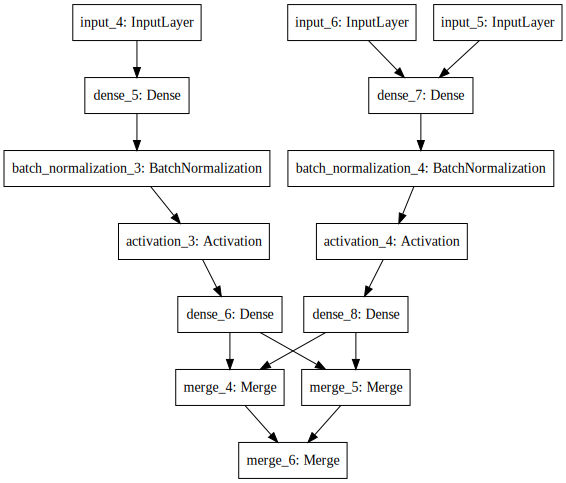

In [83]:
input_dim_spectra = spectra_latent.shape[1]
input_dim_molecule = fingerprint_arr.shape[1]
joint_embedding_model, spectra_encoder, smile_encoder = get_embedding_model(input_dim_spectra, 
                                                                            input_dim_molecule, 
                                                                            EMBEDDING_DIM)
joint_embedding_model.summary()
plot_model_in_notebook(joint_embedding_model)

In [84]:
pos = int(len(spectra_latent) * 0.8)
remaining = len(spectra_latent) - pos
print(pos, remaining)

noise = np.copy(fingerprint_arr)
fake_labels = np.zeros((len(spectra_latent), 1))

X_train = [spectra_latent[:pos], fingerprint_arr[:pos], noise[:pos]]
Y_train = fake_labels[:pos]
X_test = [spectra_latent[-remaining:], fingerprint_arr[-remaining:], noise[-remaining:]]
Y_test = fake_labels[-remaining:]

# smiles_train = fingerprint_arr[:pos]
# smiles_test = fingerprint_arr[-remaining:]
# spectra_train = fingerprint_arr[:pos]
# spectra_test = fingerprint_arr[-remaining:]

6013 1504


In [85]:
print(X_train[0].shape, X_train[1].shape, X_train[2].shape)
print(X_test[0].shape, X_test[1].shape, X_test[2].shape)

(6013, 100) (6013, 2048) (6013, 2048)
(1504, 100) (1504, 2048) (1504, 2048)


In [86]:
# rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001,
#                         verbose=1, epsilon=1e-5)
# early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
# callbacks = [rlr, early_stop]

# tensorboard = keras.callbacks.TensorBoard(log_dir='./graph', histogram_freq=0,  
#           write_graph=True, write_images=True)
# callbacks = [rlr, early_stop, tensorboard]
# if is_notebook():
#     callbacks.append(PlotLossesKeras())

TODO: generate mini-batch properly https://stackoverflow.com/questions/48568062/keras-custom-infinite-data-generator-with-shuffle

In [88]:
# actual training
for epoch in range(80):
    if epoch % 1 == 0:
        print('\nIteration %d' % epoch)
        verbose=1
    else:
        verbose=0
    np.random.shuffle(noise) # shuffle mismatched smiles
    joint_embedding_model.fit(X_train, Y_train,
        validation_data=[X_test, Y_test], epochs=1,
        batch_size=32, verbose=verbose)


Iteration 0
Train on 6013 samples, validate on 1504 samples
Epoch 1/1
6013/6013 [==============================] - 1s 195us/step - loss: 2.8272 - accuracy: 0.9652 - val_loss: 27.7410 - val_accuracy: 0.6503

Iteration 1
Train on 6013 samples, validate on 1504 samples
Epoch 1/1
6013/6013 [==============================] - 1s 199us/step - loss: 3.0097 - accuracy: 0.9641 - val_loss: 24.5400 - val_accuracy: 0.6762

Iteration 2
Train on 6013 samples, validate on 1504 samples
Epoch 1/1
6013/6013 [==============================] - 1s 198us/step - loss: 2.8097 - accuracy: 0.9672 - val_loss: 26.1308 - val_accuracy: 0.6689

Iteration 3
Train on 6013 samples, validate on 1504 samples
Epoch 1/1
6013/6013 [==============================] - 1s 190us/step - loss: 2.7882 - accuracy: 0.9661 - val_loss: 23.5779 - val_accuracy: 0.6862

Iteration 4
Train on 6013 samples, validate on 1504 samples
Epoch 1/1
6013/6013 [==============================] - 1s 197us/step - loss: 2.4775 - accuracy: 0.9717 - val_lo

6013/6013 [==============================] - 1s 219us/step - loss: 1.4604 - accuracy: 0.9825 - val_loss: 26.8043 - val_accuracy: 0.6769

Iteration 40
Train on 6013 samples, validate on 1504 samples
Epoch 1/1
6013/6013 [==============================] - 1s 206us/step - loss: 1.8054 - accuracy: 0.9795 - val_loss: 25.7538 - val_accuracy: 0.7008

Iteration 41
Train on 6013 samples, validate on 1504 samples
Epoch 1/1
6013/6013 [==============================] - 1s 207us/step - loss: 1.8825 - accuracy: 0.9772 - val_loss: 26.5551 - val_accuracy: 0.6815

Iteration 42
Train on 6013 samples, validate on 1504 samples
Epoch 1/1
6013/6013 [==============================] - 1s 209us/step - loss: 1.8569 - accuracy: 0.9792 - val_loss: 27.0158 - val_accuracy: 0.6935

Iteration 43
Train on 6013 samples, validate on 1504 samples
Epoch 1/1
6013/6013 [==============================] - 1s 211us/step - loss: 1.7514 - accuracy: 0.9795 - val_loss: 26.1573 - val_accuracy: 0.6709

Iteration 44
Train on 6013 samp

6013/6013 [==============================] - 1s 207us/step - loss: 1.1011 - accuracy: 0.9867 - val_loss: 29.3264 - val_accuracy: 0.6356

Iteration 79
Train on 6013 samples, validate on 1504 samples
Epoch 1/1
6013/6013 [==============================] - 1s 205us/step - loss: 1.2424 - accuracy: 0.9857 - val_loss: 29.5071 - val_accuracy: 0.6722


In [89]:
# joint_embedding_model.save('../models/joint_embedding_small.h5')
# spectra_encoder.save('../models/joint_spectra_encoder_small.h5')
# smile_encoder.save('../models/joint_smile_encoder_small.h5')

### Visualise the joint embedding results

In [90]:
def visualise_embedding(spectra_data, molecule_data, spectra_encoder, smile_encoder, projection='pca'):
    
    embedded_spectra = spectra_encoder.predict(spectra_data)
    embedded_molecules = smile_encoder.predict(molecule_data)
    embedded_combined = np.concatenate([embedded_spectra, embedded_molecules], axis=0)
    
    if projection == 'pca':
    
        PCA_COMPONENTS = 20
        pca = PCA(n_components = PCA_COMPONENTS)
        latent_proj = pca.fit_transform(embedded_combined)
        covariance = pca.get_covariance()
        evr = pca.explained_variance_ratio_
        print('Explained variations -- first two PCs: %.2f' % (evr[0] + evr[1]))
        print('Explained variations -- all components: %.2f' % np.sum(evr))
        print(evr)
        
    elif projection == 'tsne':
        
        TSNE_LEARNING_RATE = 750.0
        TSNE_ITERATIONS = 1000
        TSNE_COMPONENTS = 2
        TSNE_PERPLEXITY = 30.0
        print('tsne_comp=%d tsne_perplexity=%f tsne_lr=%f' % (
            TSNE_COMPONENTS,
            TSNE_PERPLEXITY,
            TSNE_LEARNING_RATE
        ))
        tsne = TSNE(n_components = TSNE_COMPONENTS,
                    perplexity = TSNE_PERPLEXITY,
                    learning_rate = TSNE_LEARNING_RATE,
                    n_iter = TSNE_ITERATIONS,
                    verbose = 4)
        latent_proj = tsne.fit_transform(embedded_combined)
        
    plt.figure(figsize=(8, 8))
    plt.scatter(latent_proj[0:len(embedded_spectra), 0], latent_proj[0:len(embedded_spectra), 1], marker='x', c='red', s=1)
    plt.scatter(latent_proj[len(embedded_spectra)+1:, 0], latent_proj[len(embedded_spectra)+1:, 1], marker='.', c='blue', s=1)
    plt.title('Joint embedding of fragmentation spectra (red) and molecules (blue)')

Visualise embedding on training data

Explained variations -- first two PCs: 0.16
Explained variations -- all components: 0.63
[0.10455393 0.05606427 0.04773567 0.04167204 0.0400124  0.03514022
 0.03264946 0.03013056 0.0267875  0.02557931 0.02321867 0.02213662
 0.0213433  0.02047223 0.01947716 0.01790637 0.0165322  0.01558884
 0.01482538 0.0137402 ]


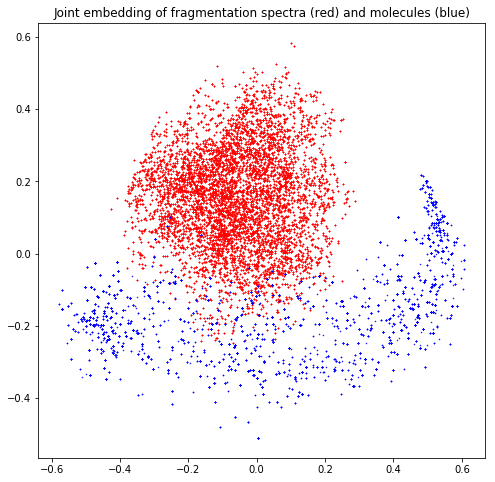

In [91]:
visualise_embedding(X_train[0], X_train[1], spectra_encoder, smile_encoder, projection='pca')

Visualise embedding on testing data

Explained variations -- first two PCs: 0.30
Explained variations -- all components: 0.74
[0.18433115 0.11108363 0.05873306 0.05072214 0.03879981 0.03187006
 0.03040959 0.02768086 0.02545684 0.02326323 0.02110685 0.01944052
 0.01920403 0.01719108 0.01618703 0.01426015 0.01392827 0.01265211
 0.01248163 0.01154145]


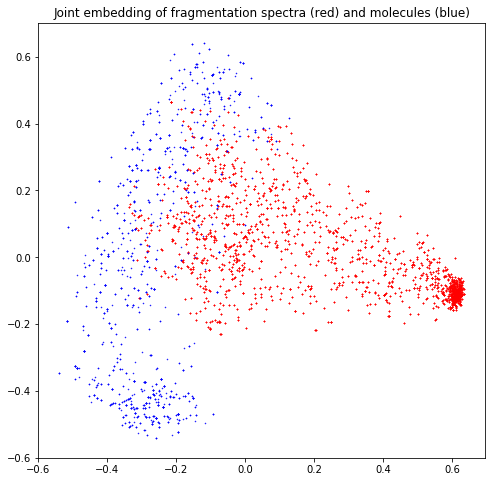

In [92]:
visualise_embedding(X_test[0], X_test[1], spectra_encoder, smile_encoder, projection='pca')

### Evaluation

In [105]:
embedded_spectra = spectra_encoder.predict(X_test[0])
embedded_molecules = smile_encoder.predict(X_test[1])

In [106]:
x = embedded_spectra[0]
print(x)
print(np.dot(x, x))

[0.         0.         0.         0.         0.         0.01350468
 0.         0.         0.         0.         0.02242567 0.
 0.26271656 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.02611066 0.         0.
 0.         0.3166295  0.         0.         0.         0.
 0.         0.15270603 0.         0.         0.12120835 0.
 0.47579467 0.         0.         0.         0.         0.
 0.36254394 0.         0.         0.         0.15565674 0.
 0.21014358 0.         0.         0.         0.         0.
 0.         0.13042119 0.04291191 0.         0.         0.
 0.         0.         0.2384072  0.         0.06800081 0.
 0.37525827 0.         0.         0.         0.         0.
 0.         0.         0.08298846 0.         0.         0.
 0.         0.         0.         0.         0.17628096 0.
 0.10942713 0.         0.         0.17014298 0.08650585 0.
 0.         0.         0.         0.24008293]
0.

In [107]:
plt.rcParams['figure.figsize'] = (8,8)

(1504, 1504)


Text(0.5,1.05,'Dot product')

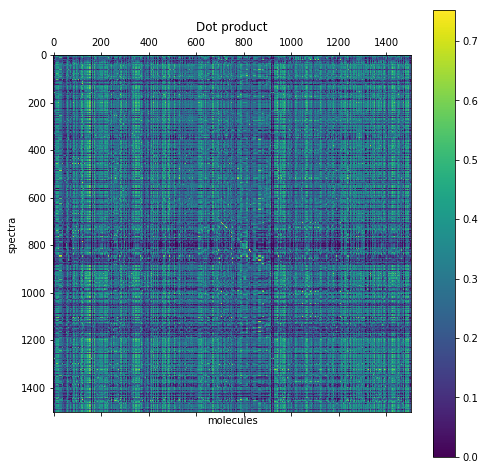

In [108]:
scores = np.dot(embedded_spectra, embedded_molecules.T)
print(scores.shape)
plt.matshow(scores)
plt.colorbar()
plt.xlabel('molecules')
plt.ylabel('spectra')
plt.title('Dot product')

In [109]:
def precision_at(n, scores):
    found = 0
    for i in range(len(scores)):
        row = scores[i]
        max_idx = row.argsort()[-n:][::-1]
        if i in max_idx:
            found += 1
#             print(i, list(zip(max_idx, row[max_idx])))
#             print()
    print('found=%d/%d %.2f' % (found, len(scores), float(found)/len(scores)))

In [110]:
precision_at(10, scores)

found=144/1504 0.10


In [50]:
def plot_spectra(idx):
    pos = np.nonzero(data['spectra'][idx])
    print(data['vocab'][pos])
    plt.plot(data['vocab'], data['spectra'][idx])
    plt.plot(data['vocab'], spectra_decoded[idx])
    plt.show()

In [53]:
plt.rcParams['figure.figsize'] = (4,4)

[136.039]


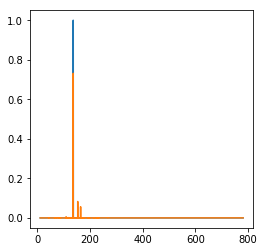

In [54]:
plot_spectra(23)

[136.039 164.07 ]


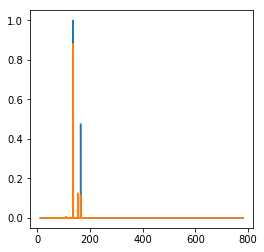

In [55]:
plot_spectra(24)

[72.984 89.038]


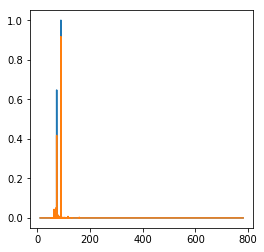

In [56]:
plot_spectra(1561)